<img src="https://i.ibb.co/qjt4Ymb/2022-09-19-004719.png" alt="2022-09-19-004719" border="0">

# AOI simple Pipeline (Part1)


# Exercise: Full solution
* Single CNN model
* ImageDataSet
* ImageDataLoader
* Submit results

AIdea AOI Project
https://aidea-web.tw/topic/285ef3be-44eb-43dd-85cc-f0388bf85ea4

## Step 1: Load the dataset from google drive
If the following command does not work, please download it, put it on your Google drive, and set up sharing

Download from:
https://drive.google.com/file/d/1tovCO2gsjesjJ8OsfHgahyt-buY34dk0/view?usp=sharing

In [ ]:
%%bash
gdown https://drive.google.com/uc?id=1_fSiJdT7X_BT_IOf23yn9x5AvvaXSFb_
unzip aoi-dataset.zip
rm aoi-dataset.zip

## Step 2: Import PyTorch libraries

In [ ]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
print (torch.cuda.is_available())

True


In [ ]:
device_name=torch.cuda.get_device_name(0)
print(f"Using GPU {device_name}")

Using GPU Tesla T4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 3: read the training set

In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv")
print(df_train.shape)

(2528, 2)


In [ ]:
df_train.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [ ]:
train_files = df_train.iloc[:,0].values
train_labels = df_train.iloc[:,1].values
print(train_labels[:10])

[0 1 1 5 5 5 3 0 3 5]


## Step 4: Show statistics of training images

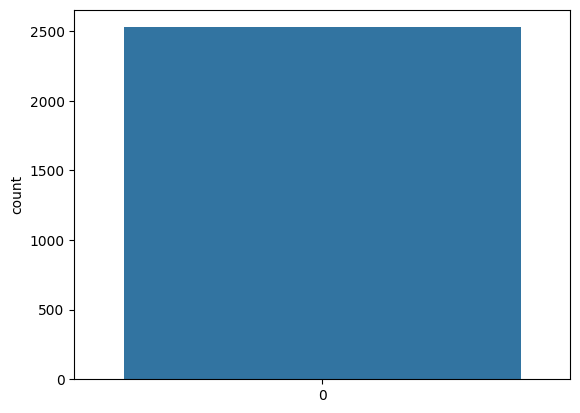

In [ ]:
import seaborn as sns
g = sns.countplot(train_labels)

## Step 5: Choose one of CNN models

### EfficientNet B0 to B7

__Model-EfficientNet__

https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

|  Base model | resolution  | Base model | resolution  |
|---|---|---|---|
| EfficientNetB0  | 224  | EfficientNetB4  | 380  |
| EfficientNetB1  | 240  | EfficientNetB5  | 456  |
| EfficientNetB2  | 260  | EfficientNetB6  | 528  |
| EfficientNetB3  | 300  | EfficientNetB7  | 600  |


In [ ]:
num_classes=6

In [ ]:
modelfile = " "

In [ ]:
import torchvision.models as models
model=models.efficientnet_b1(num_classes=num_classes)
if modelfile != None: model.load_state_dict(torch.load(modelfile))
model.cuda()

## Step 6: Instancing a dataloader
* Transforms
* CustomDataset
* dataloader

In [ ]:
from torchvision import transforms
pretrained_size = 240
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(pretrained_size, padding = 10),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])

In [ ]:
from PIL import Image
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.iloc[index]['ID']
        label = self.df.iloc[index]['Label']
        image = Image.open(os.path.join(self.images_folder, filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Step 7: Set up a train dataloader with a custom dataset

In [ ]:
batches = 24
imgdir= "train_images"
csvfile = "train.csv"

In [ ]:
train_dataset = CustomDataset(csvfile, imgdir, train_transform)
train_dataloader = DataLoader(train_dataset,batch_size=batches, shuffle=True)
print(f"Total images={len(train_dataset)}")

Total images=2528


## Step 8: total_batch

In [ ]:
total_batch=len(train_dataset)//batches + 1
print(total_batch)

106


## Step 9: Train model

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10

In [ ]:

for epoch in range(num_epochs):
  for i, (batch_images, batch_labels) in enumerate(train_dataloader):
    # Zero your gradients for every batch!
    optimizer.zero_grad()
    inputs = batch_images.cuda()
    labels = batch_labels.cuda()
    # Make predictions for this batch
    outputs  = model(inputs)

    # Compute the loss and its gradients
    cost = loss(outputs , labels)
    cost.backward()
    # Adjust learning weights
    optimizer.step()

    if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}] Loss: {cost.item():.6f}')

Epoch [1/20], lter [100/106] Loss: 0.000643
Epoch [2/20], lter [100/106] Loss: 0.004964
Epoch [3/20], lter [100/106] Loss: 0.000016
Epoch [4/20], lter [100/106] Loss: 0.001577
Epoch [5/20], lter [100/106] Loss: 0.000057
Epoch [6/20], lter [100/106] Loss: 0.000168
Epoch [7/20], lter [100/106] Loss: 0.007580
Epoch [8/20], lter [100/106] Loss: 0.000032
Epoch [9/20], lter [100/106] Loss: 0.000072


## Step 10: Save the trained model

In [ ]:
filepath = "AOI-B1"
torch.save(model.state_dict(), filepath)

## Step 11: Check training results

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])
batches =48

In [ ]:
test_dataset = CustomDataset(csvfile, imgdir, test_transform)
test_dataloader = DataLoader(test_dataset,batch_size=batches, shuffle=False)
print(f"Total images={len(test_dataset)}")

Total images=2528


In [ ]:
classes=[0,1,2,3,4,5]

In [ ]:
train_predictions = np.zeros(len(train_labels))

In [ ]:
model.eval()
# again no gradients needed
with torch.no_grad():
    total_batch = len(test_dataset)//batches
    for i, (batch_images, batch_labels) in enumerate(test_dataloader):
      images = batch_images.cuda()
      labels = batch_labels.cuda()
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      train_predictions[i*batches:(i+1)*batches] = predictions.cpu()
      if (i+1) % 10 == 0:
          print(f'lter [{i+1}/{total_batch}]')

lter [10/52]
lter [20/52]
lter [30/52]
lter [40/52]
lter [50/52]


In [ ]:
train_predictions=train_predictions.astype(int)

In [ ]:
print(train_labels[:10])

[0 1 1 5 5 5 3 0 3 5]


In [ ]:
print(train_predictions[:10])

[0 1 1 5 5 5 0 0 3 5]


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# collect the correct predictions for each class
for label, prediction in zip(train_labels, train_predictions):
    if label == prediction:
        correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')


Accuracy for class: 0 is 95.7 %
Accuracy for class: 1 is 82.5 %
Accuracy for class: 2 is 0.0 %
Accuracy for class: 3 is 60.8 %
Accuracy for class: 4 is 69.6 %
Accuracy for class: 5 is 89.9 %


## Step 12: Analyze training results


In [ ]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(train_labels, train_predictions)
print(confusion)

[[645   0   0   0   0  29]
 [ 40 406   0   0   1  45]
 [100   0   0   0   0   0]
 [113   9   0 230  20   6]
 [ 71   0   0   2 167   0]
 [  0  61   0   4   0 579]]


In [ ]:
train_num = 2528
overkill= []
underkill = []
for i,(label, prediction) in enumerate(zip(train_labels, train_predictions)):
  if label == 0 and prediction !=0:
    overkill.append(i)
  if label != 0 and prediction ==0:
    underkill.append(i)
print('# of overkill= {}; # of underkill= {} '.format(len(overkill), len(underkill)))

# of overkill= 29; # of underkill= 324 
